## Import
We are using a typical data science stack: numpy, pandas, sklearn, matplotlib.

In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## Read in Data

In [2]:
# List files available
print(os.listdir("../input/"))

['policebeats.geojson', 'Traffic_Crashes_-_Crashes.csv']


In [3]:
dtypes = {'CRASH_DATE_EST_I': 'category', 'TRAFFIC_CONTROL_DEVICE': 'category', 'DEVICE_CONDITION': 'category',
         'WEATHER_CONDITION': 'category', 'LIGHTING_CONDITION': 'category', 'FIRST_CRASH_TYPE': 'category',
         'TRAFFICWAY_TYPE': 'category', 'ROADWAY_SURFACE_COND': 'category', 'ROAD_DEFECT': 'category',
         'REPORT_TYPE': 'category', 'CRASH_TYPE': 'category', 'INTERSECTION_RELATED_I': 'category',
         'NOT_RIGHT_OF_WAY_I': 'category', 'HIT_AND_RUN_I': 'category', 'DAMAGE': 'category', 
         'PRIM_CONTRIBUTORY_CAUSE': 'category', 'SEC_CONTRIBUTORY_CAUSE': 'category', 'STREET_DIRECTION': 'category',
         'STREET_NAME': 'category', 'PHOTOS_TAKEN_I': 'category', 'STATEMENTS_TAKEN_I': 'category',
         'DOORING_I': 'category', 'WORK_ZONE_I': 'category', 'WORK_ZONE_TYPE': 'category', 'WORKERS_PRESENT_I': 'category',
         'MOST_SEVERE_INJURY': 'category'}

In [4]:
# Training data
# df = pd.read_csv('../input/Traffic_Crashes_-_Crashes.csv')
# dateparse = lambda dates: [pd.datetime.strptime(d, '%Y-%m-%d %H:%M') for d in dates] : dateparse can have list
# dateparse = lambda x: pd.datetime.strptime(x, '%m-%d-%Y %H:%M')
df = pd.read_csv('../input/Traffic_Crashes_-_Crashes.csv', parse_dates=['CRASH_DATE','DATE_POLICE_NOTIFIED'])#, date_parser=dateparse)
df.head()

,CRASH_RECORD_ID,RD_NO,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,...,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION
0,a802658be15312809c771559e4f81088cfb226830792a5...,JC172482,NaN,2013-03-03 16:48:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,SIDESWIPE OPPOSITE DIRECTION,...,0.0,2.0,1.0,0.0,16,1,3,41.975857,-87.708744,POINT (-87.708743641643 41.975856915535)
1,f62e27317feb174811cf4fefeb9fa1064fea6c0619a873...,JB442550,NaN,2014-01-18 18:14:00,30,NO CONTROLS,NO CONTROLS,CLEAR,DUSK,PARKED MOTOR VEHICLE,...,0.0,0.0,2.0,0.0,18,7,1,41.885610,-87.638756,POINT (-87.638756189808 41.885609917063)
2,957783a4787318f005a7dbc920e4c84cb9ac8aa7329a62...,HZ122950,NaN,2014-01-21 07:40:00,30,YIELD,NO CONTROLS,CLEAR,DAYLIGHT,ANGLE,...,1.0,0.0,1.0,0.0,7,3,1,41.760710,-87.561946,POINT (-87.561946030143 41.760710194223)
3,1d0232afecbdfd01968555aa956a688fd6f55a2bd1984f...,HZ164689,NaN,2014-02-24 19:45:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,RAIN,DAYLIGHT,TURNING,...,0.0,0.0,2.0,0.0,19,2,2,41.884016,-87.701143,POINT (-87.701142757538 41.884016475152)
4,964aaaeb569e364886cfbdf89ca73e09ca15cd916d87b2...,JC321679,NaN,2014-06-25 19:00:00,30,NO CONTROLS,NO CONTROLS,RAIN,DAYLIGHT,SIDESWIPE SAME DIRECTION,...,0.0,0.0,2.0,0.0,19,4,6,41.835886,-87.724474,POINT (-87.724474013253 41.835886103363)


CRASH_DATE less than 2017 has lots of missing data. we will take CRASH_DATE >= 2017

In [5]:
# creating YEAR
df['YEAR'] = pd.DatetimeIndex(df['CRASH_DATE']).year

# masking greater than YEAR 2017
mask = df['YEAR'] >= 2017

df = df.loc[mask,:]
# check the data
df['YEAR'].unique()

array([2017, 2018, 2019, 2020], dtype=int64)

In [6]:
# adding choropleth map 
import geopandas as gpd
beats = gpd.read_file("../input/policebeats.geojson")

In [7]:
# ClusterMarkder of injuries_fatal excluding 0
import folium
from folium import plugins
map=folium.Map(location=[41.881832 , -87.623177],zoom_start=10)

mask = df['INJURIES_FATAL']>0

# reset_index해주어야 함. 
fatal_df= df.loc[mask,['LATITUDE', 'LONGITUDE', 'INJURIES_FATAL']].groupby(['LATITUDE','LONGITUDE']).sum().reset_index()
fatal_df.columns

fatal_map=plugins.MarkerCluster().add_to(map)  #Marking Cluster Objects for Data Events
type(fatal_map)

#Put data into the cluster object above
for lat,lng,label, in zip(fatal_df['LATITUDE'],fatal_df['LONGITUDE'], fatal_df['INJURIES_FATAL']):
    folium.Marker(
    location=[lat,lng],
    icon=None,
    popup=label,
    ).add_to(fatal_map)
map.save('../output/injury_fatal_custerMarker_final.html')    
map

## EDA
The goal of EDA is to learn what our data can tell us. It generally starts out with a high level overview, then narrows in to specific areas as we find intriguing areas of the data.

Examine the Distribution of the Target Column
The target is what we are asked to predict:

- 0 for the damage less than $1,500

- 1 indicating the damage is more than $1,500 which is considered reportable crashes according to Illinois statute.

In [36]:
df_train = df.copy()

In [37]:
df_train['TARGET'] = df_train['DAMAGE'].map(lambda x: 1 if x=='OVER $1,500' else 0)

1    191431
0    142992
Name: TARGET, dtype: int64


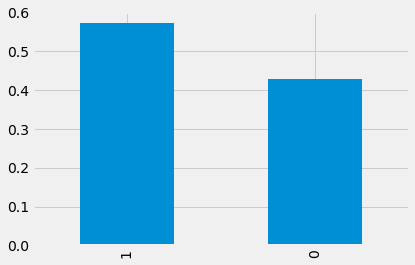

In [38]:
print(df_train['TARGET'].value_counts())
df_train['TARGET'].value_counts(normalize=True).plot(kind='bar')

### Examine Missing Values
Next we can look at the number and percentage of missing values in each column.

In [39]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mask = (mis_val_table_ren_columns.iloc[:,1] != 0) # % 가 0이 아닌 행
        mis_val_table_ren_columns = mis_val_table_ren_columns[mask].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [40]:
# Missing values statistics
missing_values = missing_values_table(df_train)
missing_values.head(20)

Your selected dataframe has 51 columns.
There are 26 columns that have missing values.


,Missing Values,% of Total Values
WORKERS_PRESENT_I,333856,99.8
DOORING_I,333290,99.7
WORK_ZONE_TYPE,332635,99.5
WORK_ZONE_I,332176,99.3
PHOTOS_TAKEN_I,330353,98.8
STATEMENTS_TAKEN_I,327358,97.9
NOT_RIGHT_OF_WAY_I,318860,95.3
CRASH_DATE_EST_I,311241,93.1
INTERSECTION_RELATED_I,257768,77.1
HIT_AND_RUN_I,240962,72.1


- When it comes time to build our machine learning models, we will have to fill in these missing values (known as imputation). 
- In later work, we will use models such as XGBoost that can handle missing values with no need for imputation. 
- Another option would be to drop columns with a high percentage of missing values, although it is impossible to know ahead of time if these columns will be helpful to our model.
- *Therefore, we will keep all of the columns for now.*

### Column Types
Let's look at the number of columns of each data type. 
- int64 and float64 are numeric variables (which can be either discrete or continuous). 
- Object columns contain strings and are categorical features.
- datetime64 contains date features

In [41]:
# Number of each type of column
df_train.dtypes.value_counts()

object            30
float64           12
int64              7
datetime64[ns]     2
dtype: int64

Let's now look at the number of unique entries in each of the object (categorical) columns.

In [42]:
# Number of unique classes in each object column - once only.
df_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

CRASH_RECORD_ID            334423
RD_NO                      330026
CRASH_DATE_EST_I                2
TRAFFIC_CONTROL_DEVICE         19
DEVICE_CONDITION                8
WEATHER_CONDITION              12
LIGHTING_CONDITION              6
FIRST_CRASH_TYPE               18
TRAFFICWAY_TYPE                20
ALIGNMENT                       6
ROADWAY_SURFACE_COND            7
ROAD_DEFECT                     7
REPORT_TYPE                     2
CRASH_TYPE                      2
INTERSECTION_RELATED_I          2
NOT_RIGHT_OF_WAY_I              2
HIT_AND_RUN_I                   2
DAMAGE                          3
PRIM_CONTRIBUTORY_CAUSE        40
SEC_CONTRIBUTORY_CAUSE         40
STREET_DIRECTION                4
STREET_NAME                  1498
PHOTOS_TAKEN_I                  2
STATEMENTS_TAKEN_I              2
DOORING_I                       2
WORK_ZONE_I                     2
WORK_ZONE_TYPE                  4
WORKERS_PRESENT_I               2
MOST_SEVERE_INJURY              5
LOCATION      

Most of the categorical variables have a relatively small number of unique entries, some of larger unique entries. We will need to find a way to deal with these categorical variables! I will drop more than 60% missing and not relavent to modeling(CRASH_RECORD_ID, RD_NO, LOCATION)                                        

In [43]:
df_train_0 = df_train.drop(columns=['CRASH_RECORD_ID', 'RD_NO', 'LOCATION','DAMAGE'],axis=1)


df_train_0 = df_train_0.dropna(axis=1,thresh=len(df_train_0)*0.4)
df_train_0.columns

Index(['CRASH_DATE', 'POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE',
       'DEVICE_CONDITION', 'WEATHER_CONDITION', 'LIGHTING_CONDITION',
       'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE', 'LANE_CNT', 'ALIGNMENT',
       'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'REPORT_TYPE', 'CRASH_TYPE',
       'DATE_POLICE_NOTIFIED', 'PRIM_CONTRIBUTORY_CAUSE',
       'SEC_CONTRIBUTORY_CAUSE', 'STREET_NO', 'STREET_DIRECTION',
       'STREET_NAME', 'BEAT_OF_OCCURRENCE', 'NUM_UNITS', 'MOST_SEVERE_INJURY',
       'INJURIES_TOTAL', 'INJURIES_FATAL', 'INJURIES_INCAPACITATING',
       'INJURIES_NON_INCAPACITATING', 'INJURIES_REPORTED_NOT_EVIDENT',
       'INJURIES_NO_INDICATION', 'INJURIES_UNKNOWN', 'CRASH_HOUR',
       'CRASH_DAY_OF_WEEK', 'CRASH_MONTH', 'LATITUDE', 'LONGITUDE', 'YEAR',
       'TARGET'],
      dtype='object')

In [44]:
df_train_0.info()
len(df_train_0)*0.4
# df_train_1['LANE_CNT']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334423 entries, 54170 to 388592
Data columns (total 37 columns):
CRASH_DATE                       334423 non-null datetime64[ns]
POSTED_SPEED_LIMIT               334423 non-null int64
TRAFFIC_CONTROL_DEVICE           334423 non-null object
DEVICE_CONDITION                 334423 non-null object
WEATHER_CONDITION                334423 non-null object
LIGHTING_CONDITION               334423 non-null object
FIRST_CRASH_TYPE                 334423 non-null object
TRAFFICWAY_TYPE                  334423 non-null object
LANE_CNT                         153210 non-null float64
ALIGNMENT                        334423 non-null object
ROADWAY_SURFACE_COND             334423 non-null object
ROAD_DEFECT                      334423 non-null object
REPORT_TYPE                      325874 non-null object
CRASH_TYPE                       334423 non-null object
DATE_POLICE_NOTIFIED             334423 non-null datetime64[ns]
PRIM_CONTRIBUTORY_CAUSE      

133769.2

### Encoding Categorical Variables
A machine learning model unfortunately cannot deal with categorical variables (except for some models such as LightGBM). Therefore, we have to find a way to represent these variables as numbers before handing them off to the model. There are two main ways to carry out this process:

```Labeling encoding```:

When we perform label encoding, the model might use the relative value of the feature (for example North(STREET_DIRECTION) = 4 and West(STREET_DIRECTION) = 1) to assign weights which is not what we want. If we only have two unique values for a categorical variable (such as Male/Female), then label encoding is fine, but for more than 2 unique categories, one-hot encoding is the safe option.

The only downside to ```one-hot encoding``` is that the number of features (dimensions of the data) can explode with categorical variables with many categories. To deal with this, we can perform one-hot encoding followed by PCA or other dimensionality reduction methods to reduce the number of dimensions (while still trying to preserve information).

In this notebook, 
- Labeling encoding for any categorical variables with only 2 categories.
- One-Hot Encoding for any categorical variables with more than 2 categories. 

In [45]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in df_train_0:
    if df_train_0[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(df_train_0[col].unique())) <= 2: #app_train[col].nunique() not working...
            # Train on the training data
            le.fit(df_train_0[col])
            # Transform both training and testing data
            df_train_0[col] = le.transform(df_train_0[col])
#             app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

1 columns were label encoded.


There are nan values.  

In [46]:
list(df_train_0['REPORT_TYPE'].unique())

['NOT ON SCENE (DESK REPORT)', 'ON SCENE', nan]

### Label Encoding and One-Hot Encoding
Let's implement the policy described above: for any categorical variable (dtype == object) with 2 unique categories, we will use label encoding, and for any categorical variable with more than 2 unique categories, we will use one-hot encoding.

For label encoding, we use the Scikit-Learn LabelEncoder and for one-hot encoding, the pandas get_dummies(df) function.



In [47]:
df_train_imputed = pd.get_dummies(df_train_0)
# df_test = pd.get_dummies(df_test)

print('Training Features shape: ', df_train_imputed.shape)
# print('Testing Features shape: ', app_test.shape)

Training Features shape:  (334423, 1714)


### Back to Exploratory Data Analysis
Anomalies
One problem we always want to be on the lookout for when doing EDA is anomalies within the data.

These may be due to mis-typed numbers,
errors in measuring equipment,
or they could be valid but extreme measurements.
One way to support anomalies quantitatively is by looking at the statistics of a column using the describe method.

In [48]:
df_lane = df_train_imputed.loc[:,'LANE_CNT']
df_lane.dropna().describe()

count    1.532100e+05
mean     1.653912e+01
std      3.375350e+03
min      0.000000e+00
25%      2.000000e+00
50%      2.000000e+00
75%      4.000000e+00
max      1.191625e+06
Name: LANE_CNT, dtype: float64

That doesn't look right! The maximum value is more than 1000 lines!

In [49]:
df_lane = df_lane.dropna()
df_lane.sort_values(ascending=False)[0:10]

65645     1191625.0
103844     433634.0
79641      299679.0
69196      218474.0
75911         902.0
104480        400.0
120708        100.0
65028          99.0
79088          99.0
72567          99.0
Name: LANE_CNT, dtype: float64

In [50]:
df_lane.value_counts().unique()

array([71112, 38122, 25018,  6591,  5581,  3260,  1543,  1473,   148,
         127,    61,    58,    29,    25,    10,     9,     6,     5,
           4,     3,     2,     1], dtype=int64)

Just out of curiousity, let's subset the anomalous lanes and see if they tend to have higher or low rates of high damage than the rest of the lanes.

In [51]:
anom = df_train_imputed.loc[df_train_imputed['LANE_CNT'] >15,:] # bigger than 50 lanes seems not normal
non_anom = df_train_imputed.loc[df_train_imputed['LANE_CNT'] < 15,:]
print('The non-anomalies damage-high on %0.2f%% of damage' % (100 * non_anom['TARGET'].mean()))
print('The anomalies damage-high on %0.2f%% of damage' % (100 * anom['TARGET'].mean()))
# print('There are %d anomalous days of employment' % len(anom))

The non-anomalies damage-high on 58.40% of damage
The anomalies damage-high on 56.36% of damage


Well that is interesting! It turns out that the anomalies have a lower rate of hige-damage.

Handling the anomalies depends on the exact situation, with no set rules. One of the safest approaches is just to set the anomalies to a missing value and then have them filled in (using Imputation) before machine learning. The anomalous values seem to have some importance, so we want to tell the machine learning model if we did in fact fill in these values.

- As a solution, we will fill in the anomalous values with not a number (np.nan) and then create a new boolean column indicating whether or not the value was anomalous.

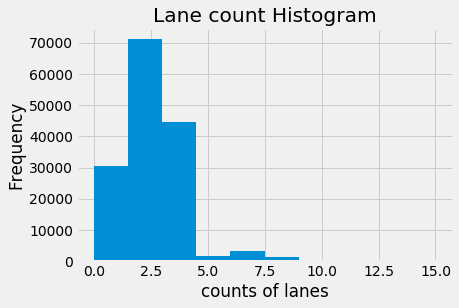

In [52]:
# Create an anomalous flag column
df_train_imputed['LANE_CNT_ANOM'] = df_train_imputed["LANE_CNT"] > 15

# Replace the anomalous values with nan
df_train_imputed['LANE_CNT'] = df_train_imputed['LANE_CNT'].map(lambda x: np.nan if x>15 else x )


df_train_imputed['LANE_CNT'].plot.hist(title = 'Lane count Histogram');
plt.xlabel('counts of lanes');

In [59]:
print('There are %d anomalies in the train data out of %d entries' % (df_train_imputed["LANE_CNT_ANOM"].sum(), len(df_train_imputed)))

There are 110 anomalies in the train data out of 334423 entries


The distribution looks to be much more in line with what we would expect, and we also have created a new column to tell the model that these values were originally anomalous (becuase we will have to fill in the nans with some value, probably the median of the column). 

### Correlations
Now that we have dealt with the categorical variables and the outliers, let's continue with the EDA. One way to try and understand the data is by looking for correlations between the features and the target. We can calculate the Pearson correlation coefficient between every variable and the target using the .corr dataframe method.

The correlation coefficient is not the greatest method to represent "relevance" of a feature, but it does give us an idea of possible relationships within the data. Some general interpretations of the absolute value of the correlation coefficent are:

- 00-.19 “very weak”
- 20-.39 “weak”
- 40-.59 “moderate”
- 60-.79 “strong”
- 80-1.0 “very strong”

In [ ]:
# Find correlations with the target and sort
correlations = df_train_imputed.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

#takes long time...

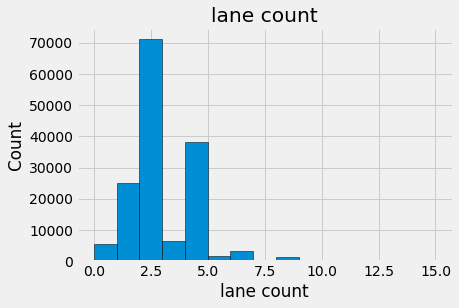

In [57]:
# Set the style of plots
app_train = df_train_imputed.copy() # easy typing

app_train_lane = app_train.loc[:,['LANE_CNT','TARGET']]
app_train_lane_1 = app_train_lane.dropna()

plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(app_train_lane_1['LANE_CNT'], edgecolor = 'k', bins = 15)
plt.title('lane count'); plt.xlabel('lane count'); plt.ylabel('Count');

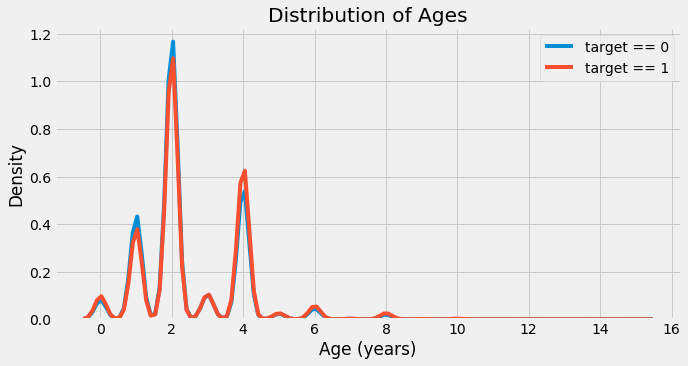

In [58]:
plt.figure(figsize = (10, 5))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train_lane_1.loc[app_train_lane_1['TARGET'] == 0, 'LANE_CNT'] , label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train_lane_1.loc[app_train_lane_1['TARGET'] == 1, 'LANE_CNT'] , label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

when the lower number of lans such as 1,2 there are more in low-damage, but after lane 4, high-damage gets higher. I think this is ok variable into the model. 

### heat map for some important variables


In [73]:
# Extract the EXT_SOURCE variables and show correlations
injury_data = app_train[['TARGET', 'LANE_CNT', 'NUM_UNITS', 'INJURIES_TOTAL', 'INJURIES_FATAL']]
injury_data_corrs = injury_data.corr()
injury_data_corrs

,TARGET,LANE_CNT,NUM_UNITS,INJURIES_TOTAL,INJURIES_FATAL
TARGET,1.000000,0.042604,0.076047,0.103228,0.015117
LANE_CNT,0.042604,1.000000,0.011705,0.064422,0.006605
NUM_UNITS,0.076047,0.011705,1.000000,0.105969,0.000280
INJURIES_TOTAL,0.103228,0.064422,0.105969,1.000000,0.088092
INJURIES_FATAL,0.015117,0.006605,0.000280,0.088092,1.000000


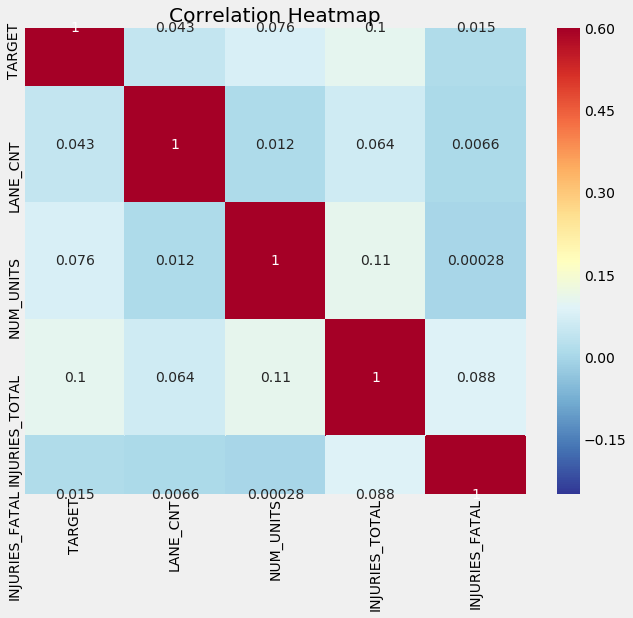

In [78]:
plt.figure(figsize = (10, 8))

# Heatmap of correlations
sns.heatmap(injury_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

All numeric featureshave possitive correlations with the target, indicating that as the value of the numeric variables increases, the damage is more likely high.

Next we can look at the distribution of each of these features colored by the value of the target. This will let us visualize the effect of this variable on the target.


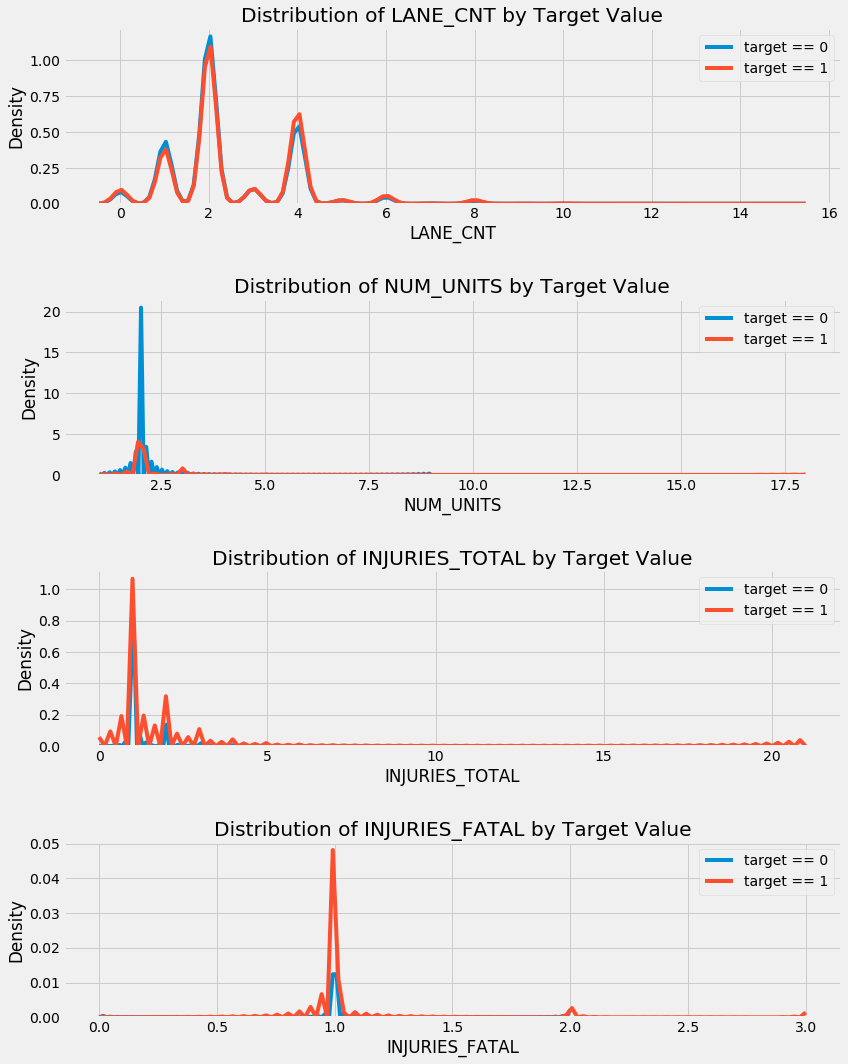

In [79]:

plt.figure(figsize = (12, 15))

# iterate through the sources
for i, source in enumerate(['LANE_CNT', 'NUM_UNITS', 'INJURIES_TOTAL', 'INJURIES_FATAL']):
    
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

## Modeling
### Logistic Regression Implementation

To get a baseline, we will use all of the features after encoding the categorical variables. We will preprocess the data by filling in the missing values (imputation) and normalizing the range of the features (feature scaling). The following code performs both of these preprocessing steps.

In [85]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

app_train = app_train.drop(columns=['CRASH_DATE', 'DATE_POLICE_NOTIFIED']) # drop time_stamp

# Drop the target from the training data
if 'TARGET' in app_train:
    train = app_train.drop(columns = ['TARGET'])
else:
    train = app_train.copy()
    
# Feature names
features = list(train.columns)

# Median imputation of missing values
imputer = SimpleImputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)


# Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)


print('Training data shape: ', train.shape)


KeyboardInterrupt: 

In [ ]:
from sklearn.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C = 0.0001)

# Train on the training data
log_reg.fit(train, train_labels)